# 5조 - 오조오억번
# 강우 예측 AI 알고리즘 개발 프로젝트

## 1. Import modules

In [1]:
from google.colab import drive
import zipfile
import glob

import pandas as pd
import numpy as np
np.random.seed(2)

import matplotlib.pylab as plt
import matplotlib.image as mpimg
%matplotlib inline

import PIL.Image as pilimg
import imgaug
import cv2
import itertools
import os
import gc

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error

from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import *   # Conv2D, Conv2DTranspose, MaxPooling2D, MaxPool2D, BatchNormalization, concatenate, Input, Dense, Dropout, UpSampling2D
from tensorflow.keras.models import *   
from tensorflow.keras.optimizers import *   # Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import *
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings("ignore")

print('tf version:', tf.__version__)

tf version: 2.3.0


## 2. Load train data

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/final_prj'

zip_file = zipfile.ZipFile(path+'/train.zip')
zip_file.extractall('.')

In [4]:
# 구글드라이브 train data 파일 경로 지정
train_files = sorted(glob.glob('/content/train/*.npy'))
train_files = np.array(train_files)   # [:1000])    

In [5]:
# C드라이브 train data 파일 경로 지정
# train_files = glob.glob('C:\\AIP\\rainy_project\\venv\\data\\train/*.npy')
# train_files = np.array(train_files[:1000])

In [6]:
print(len(train_files))
print(train_files[1])

62735
/content/train/train_00001.npy


## 3. Split Target vs. Feature

In [7]:
pix=[]
y = []
x = []
for i in range(1000) :   # len(train_files)) :
    im = np.load(train_files[i])
    im.resize(120, 120, 5)
    target= im[:,:,-1]
    feature=[]
    for j in range(4):
        feature.append(im[:,:,j])
    # print(feature[0].type)
    pix.append(im)
    y.append(target)
    x.append(feature)
    if i %5000 == 0:
        print(i)
np.array(x).shape
# x.type

0


(1000, 4, 120, 120)

## 4. Plot

In [8]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
image_sample_x = x[2]   # np.load(train_files[20])
image_sample_y = y[2]

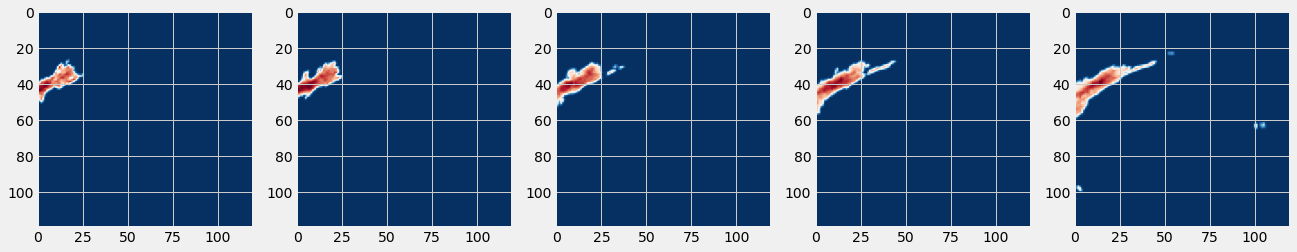

In [9]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 20))
image_sample_x=np.array(image_sample_x)
image_sample_y=np.array(image_sample_y)
for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(image_sample_x[i,:, :], cmap=color_map)

plt.subplot(1,5,5)
plt.imshow(image_sample_y, cmap = color_map)
plt.show()

## 5. Split Training vs. Validation data

In [10]:
x=np.array(x)
y=np.array(y)
x.resize(1000, 4, 120,120,1)
y.resize(1000, 1, 120,120,1)

X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size = 0.2, random_state=42)

In [11]:
np.array(X_train).shape

(800, 4, 120, 120, 1)

In [12]:
np.array(X_val).shape

(200, 4, 120, 120, 1)

In [13]:
np.array(Y_train).shape

(800, 1, 120, 120, 1)

In [14]:
np.array(Y_val).shape

(200, 1, 120, 120, 1)

## 6. Modeling

### - ConvLSTM

In [15]:
# model = keras.Sequential(
#     [
#         keras.Input(shape=(None, 120, 120, 1)),
#         layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True),
#         layers.BatchNormalization(),
#         layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True),
#         layers.BatchNormalization(),
#         layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True),
#         layers.BatchNormalization(),
#         layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True),
#         layers.BatchNormalization(),
#         layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True),
#         layers.BatchNormalization(),
#         layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True),
#         layers.BatchNormalization(),
#         layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation="relu", padding="same"),
#     ]
# )

# model.compile(loss='mae', optimizer='adam')
# model.summary()

In [16]:
# pretrained_weights=None
input_size=(None, 120, 120, 1)
inputs = Input(input_size)

conv1 = TimeDistributed(Conv2D(64, 3, activation='relu', padding='same'))(inputs)   # , kernel_initializer='he_normal'
conv1 = TimeDistributed(Conv2D(64, 3, activation='relu', padding='same'))(conv1)      # , kernel_initializer='he_normal'
pool1 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(conv1)

conv2 = TimeDistributed(Conv2D(128, 3, activation='relu', padding='same'))(pool1)   # , kernel_initializer='he_normal'
conv2 = TimeDistributed(Conv2D(128, 3, activation='relu', padding='same'))(conv2)   # , kernel_initializer='he_normal'
pool2 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(conv2)

# conv3 = TimeDistributed(Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal'))(pool2)
# conv3 = TimeDistributed(Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal'))(conv3)
# pool3 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(conv3)

# conv4 = TimeDistributed(Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal'))(pool3)
# conv4 = TimeDistributed(Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal'))(conv4)
# drop4 = Dropout(0.5)(conv3)
# pool4 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(drop4)

conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool2)   # , kernel_initializer='he_normal'
conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)   # , kernel_initializer='he_normal'
drop5 = Dropout(0.5)(conv5)

# up6 = ConvLSTM2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal', return_sequences=True)(TimeDistributed(UpSampling2D(size=(2, 2)))(drop5))
# merge6 = concatenate([drop4, up6], axis=4)
# conv6 = ConvLSTM2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', return_sequences=True)(merge6)
# conv6 = ConvLSTM2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', return_sequences=True)(conv6)

# up7 = ConvLSTM2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal', return_sequences=True)(TimeDistributed(UpSampling2D(size=(2, 2)))(drop5))
# merge7 = concatenate([conv3, up7], axis=4)
# conv7 = ConvLSTM2D(256, 3, padding='same', return_sequences=True)(merge7)
# conv7 = ConvLSTM2D(256, 3, padding='same', return_sequences=True)(conv7)

up8 = ConvLSTM2D(128, 2, padding='same',return_sequences=True)(TimeDistributed(UpSampling2D(size=(2, 2)))(drop5))
merge8 = concatenate([conv2, up8], axis=4)
conv8 = ConvLSTM2D(128, 3, padding='same', return_sequences=True)(merge8)
conv8 = ConvLSTM2D(128, 3, padding='same', return_sequences=True)(conv8)

up9 = ConvLSTM2D(64, 2, padding='same', return_sequences=True)(TimeDistributed(UpSampling2D(size=(2, 2)))(conv8))
merge9 = concatenate([conv1, up9], axis=4)
conv9 = ConvLSTM2D(64, 3, padding='same', return_sequences=True)(merge9)
conv9 = ConvLSTM2D(64, 3, padding='same', return_sequences=True)(conv9)
# conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
# conv9 = ConvLSTM2D(2, 3, padding='same', return_sequences=True)(conv9)
# conv10 = ConvLSTM2D(3, 1, activation='softmax', return_sequences=True)(conv9)
conv10 = Conv2D(2, 1, activation='relu', padding='same')(conv9)

model = Model(inputs, conv10)
model.compile(loss='mae', optimizer='adam')   # (lr=1e-4)
model.summary()
    # if (pretrained_weights):
    #   model.load_weights(pretrained_weights) 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 120, 1 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 120, 12 640         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 120, 12 36928       time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, None, 60, 60, 0           time_distributed_1[0][0]         
_______________________________________________________________________________________

In [17]:
callbacks = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss', factor=0.2, patience=2, verbose=0, mode='min',
  min_delta=0.0001, cooldown=0, min_lr=0)

history = model.fit(X_train, Y_train, batch_size=8, epochs=100, verbose=1, validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - 147s 1s/step - loss: 13.5738 - val_loss: 12.8615
Epoch 2/100
100/100 [==============================] - 144s 1s/step - loss: 12.9180 - val_loss: 12.2914
Epoch 3/100
100/100 [==============================] - 144s 1s/step - loss: 12.3421 - val_loss: 11.7559
Epoch 4/100
100/100 [==============================] - 144s 1s/step - loss: 11.7824 - val_loss: 11.2206
Epoch 5/100
100/100 [==============================] - 144s 1s/step - loss: 11.2318 - val_loss: 10.6931
Epoch 6/100
100/100 [==============================] - 144s 1s/step - loss: 10.6930 - val_loss: 10.1857
Epoch 7/100
100/100 [==============================] - 144s 1s/step - loss: 10.1539 - val_loss: 9.6796
Epoch 8/100
100/100 [==============================] - 144s 1s/step - loss: 9.6236 - val_loss: 9.2016
Epoch 9/100
100/100 [==============================] - 144s 1s/step - loss: 9.1044 - val_loss: 8.7399
Epoch 10/100
100/100 [==============================] - 144s 1s/step 

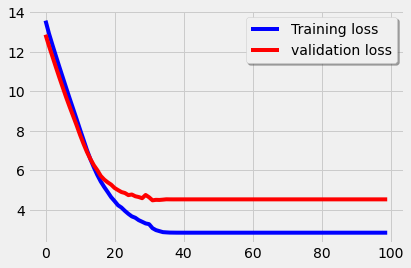

In [18]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.legend(loc='best', shadow=True)
plt.show()